In [25]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [26]:
binning = np.linspace(0.0, 22.9, 9) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 22.9, 24)

## Define the NP model in WC space

In [27]:
cvl = 12.0
cvr = 0.0
csl = 4.0
csr = 0.0
ctl = 5.0

## Compute number of samples to produce

In [28]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [29]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=8888))

Pre-runs:  20%|██        | 1/5 [00:00<00:00,  4.66it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [30]:
np.random.seed(2222)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

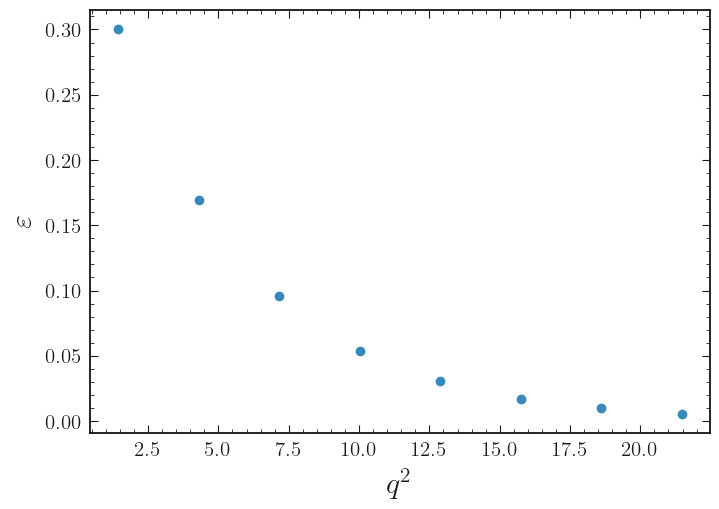

In [31]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

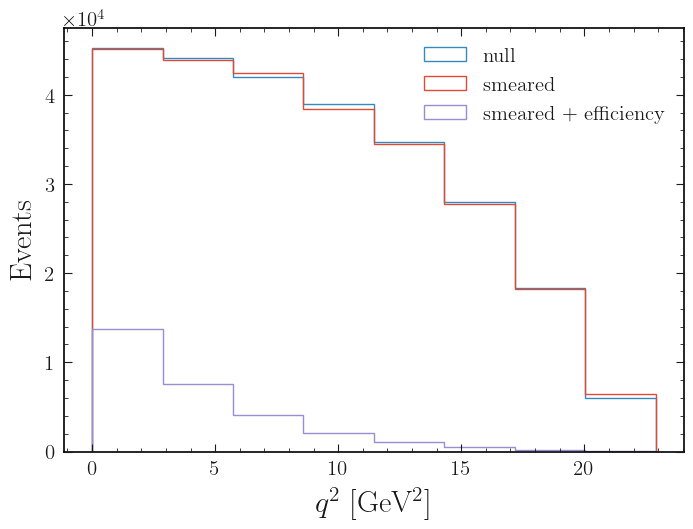

In [32]:
plt.hist(null_samples, binning, histtype='step', label='null')
plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, weights = efficiency(null_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.ylabel(r'Events')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [33]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=9999))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [34]:
np.random.seed(4444)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

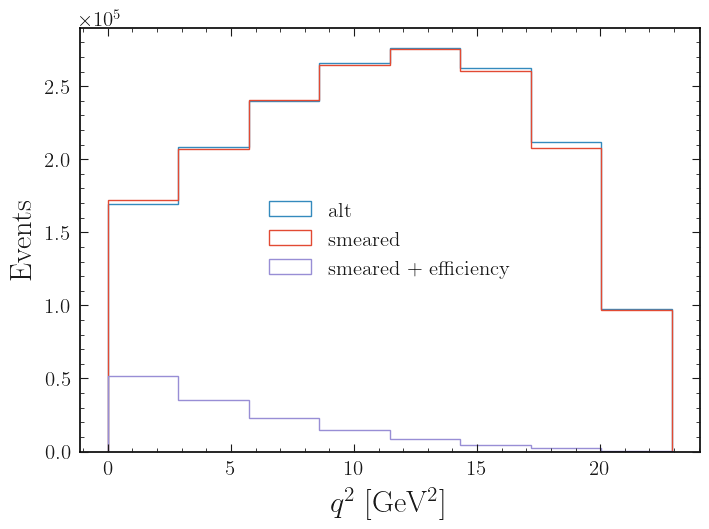

In [35]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, weights = efficiency(alt_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.ylabel(r'Events')
plt.legend()

### Plot samples and calculate yields

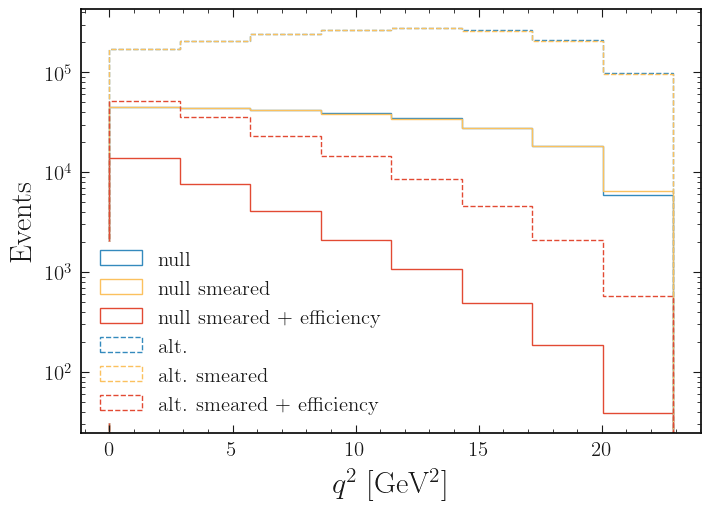

In [78]:
plt.hist(null_samples, binning, histtype='step', label='null', color='C0')
plt.hist(null_samples_smeared, binning, histtype='step', label='null smeared', color='C4')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, weights = efficiency(null_samples_smeared), histtype='step', label='null smeared + efficiency', color='C1')

plt.gca().set_prop_cycle(None)

plt.hist(alt_samples, binning, histtype='step', label='alt.', linestyle='dashed', color='C0')
plt.hist(alt_samples_smeared, binning, histtype='step', label='alt. smeared', linestyle='dashed', color='C4')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, weights = efficiency(alt_samples_smeared), histtype='step', label='alt. smeared + efficiency', linestyle='dashed', color='C1')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.ylabel(r'Events')

plt.yscale('log')
plt.legend(loc="lower left")

In [36]:
print('# SM samples', SMsamples)
print('# SM yields', sum(null_yields))
print('# BSM samples', BSMBR/SMBR * SMsamples)
print('# BSM yields', sum(alt_yields))
print('ratio BSM/SM samples', BSMBR/SMBR)
print('ratio BSM/SM yields', sum(alt_yields)/sum(null_yields))

# SM samples 257193
# SM yields 29335.970940027073
# BSM samples 1731595.6674635524
# BSM yields 140448.17697236815
ratio BSM/SM samples 6.732670280542442
ratio BSM/SM yields 4.787575541968359


## Set up the mapping distribution

In [37]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [38]:
null = null_pred()
alt = alt_pred()

In [39]:
ana = analysis()

fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [40]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 5000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


In [41]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((3., 14.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFK'   :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

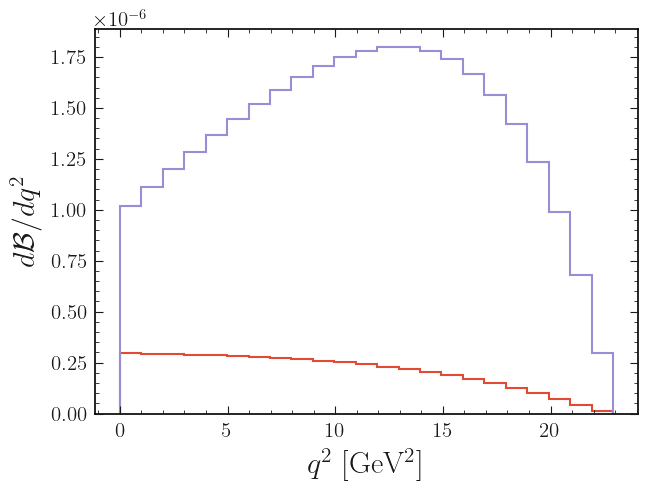

In [42]:
pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Target bins'>)

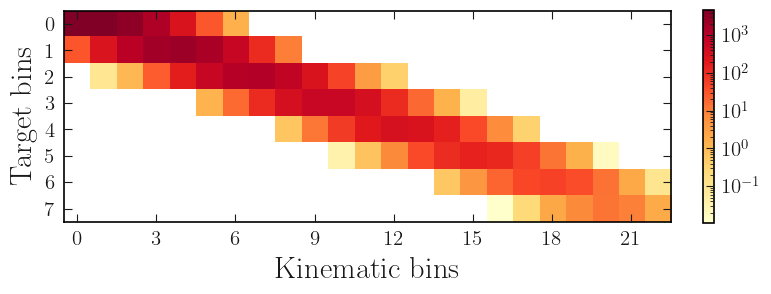

In [43]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [44]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->Knunu',
   'samples': [{'name': 'signal',
     'data': [13770.458013244752,
      7554.683320524466,
      4115.059731187786,
      2111.138435392757,
      1071.466589651256,
      489.8628568032327,
      184.6906948181895,
      38.611298404634],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [117.34759483365968,
        86.9176812882423,
        64.1487313295266,
        45.947126519432715,
        32.733264268191405,
        22.132845655342937,
        13.590095467589236,
        6.213799031561448]},
      {'name': 'knunu_theory',
       'type': 'knunu',
       'data': {'expr': 'knunu_weight_fn'}}]}]}]}

## Save and load model

In [45]:
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [46]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']]  = [True]
fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

# for i in range(3, 8):
#     fixed[model.config.par_map[f'FFK_decorrelated[{i}]']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 1.13307


{'cvl': array([11.95060689,  0.39613473]),
 'cvr': array([0.001, 0.   ]),
 'csl': array([4.30474109, 0.80934162]),
 'csr': array([0.001, 0.   ]),
 'ctl': array([4.95963676, 0.46477234]),
 'FFK_decorrelated[0]': array([0.0201415 , 0.95650468]),
 'FFK_decorrelated[1]': array([-0.00735317,  0.99937887]),
 'FFK_decorrelated[2]': array([-0.01186814,  0.96631053]),
 'FFK_decorrelated[3]': array([0.00716629, 0.98710405]),
 'FFK_decorrelated[4]': array([-0.00634331,  0.99862857]),
 'FFK_decorrelated[5]': array([-1.22365920e-04,  9.73912138e-01]),
 'FFK_decorrelated[6]': array([-0.0017807 ,  0.97834034]),
 'FFK_decorrelated[7]': array([-0.00186098,  0.99963922]),
 'mu': array([1., 0.]),
 'stat': [[0.9998479902271049, 0.008254142422757904],
  [1.0020103040934298, 0.008023270068952426],
  [0.9921094985615533, 0.010590117359444817],
  [1.0109229699474005, 0.013487812791780518],
  [0.9982720789928768, 0.017053525365594846],
  [0.9953731932090797, 0.024933165505884536],
  [0.9981040761976115, 0.0487

In [47]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 11.950606892517845,
 'cvr': 0.001,
 'csl': 4.3047410928451555,
 'csr': 0.001,
 'ctl': 4.959636755254963,
 'FFK[0]': 0.3378644167158807,
 'FFK[1]': -0.88541620739198,
 'FFK[2]': -0.11198749997969103,
 'FFK[3]': 0.3732120942117723,
 'FFK[4]': 0.07689386010757142,
 'FFK[5]': 0.3263509378968713,
 'FFK[6]': -0.9669165832622806,
 'FFK[7]': -0.28570975227734174,
 'mu': 1.0,
 'stat': [0.9998479902271049,
  1.0020103040934298,
  0.9921094985615533,
  1.0109229699474005,
  0.9982720789928768,
  0.9953731932090797,
  0.9981040761976115,
  1.005719224938762]}

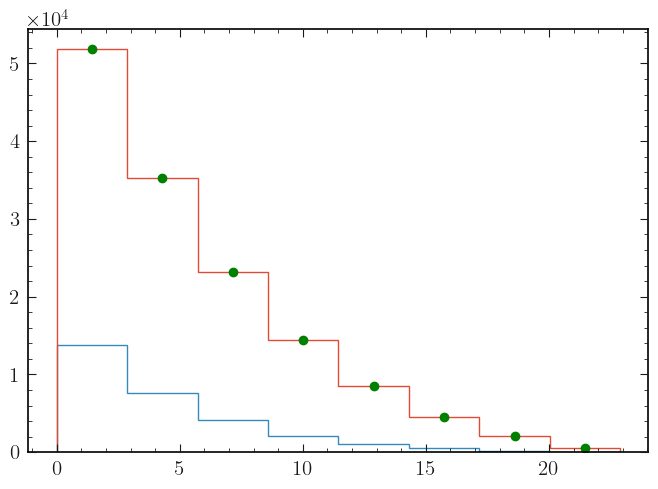

In [48]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')